# Algorithmic Collusion with Reinforcement Learning: Modeling Competition Among Firms  

## Objective 
The goal of this notebook is to simulates a market model with two firms competing through pricing strategies. The code has been adjusted such that each firm has no memory. Moving average plots will be analysed to see how agents react to devaitions.

## Bertrand Duopoly Implementation 

In [ ]:
"""
Model of algorithms and competition
"""

import numpy as np
from itertools import product
from scipy.optimize import fsolve


class model(object):
    """
    model

    Attributes
    ----------
    n : int
        number of players
    alpha : float
        product differentiation parameter
    beta : float
        exploration parameter
    delta : float
        discount factor
    mu : float
        product differentiation parameter
    a : int
        value of the products
    a0 : float
        value of the outside option
    c : float
        marginal cost
    k : int
        dimension of the grid
    stable: int
        periods of game stability
    """

    def __init__(self, **kwargs):
        """Initialize game with default values"""
        # Default properties
        self.n = kwargs.get('n', 2)
        self.alpha = kwargs.get('alpha', 0.15)
        self.beta = kwargs.get('beta', 4e-6)
        self.delta = kwargs.get('delta', 0.95)
        self.c = kwargs.get('c', 1)
        self.a = kwargs.get('a', 2)
        self.a0 = kwargs.get('a0', 0)
        self.mu = kwargs.get('mu', 0.25)
        self.k = kwargs.get('k', 15)
        self.tstable = kwargs.get('tstable', 1e5)
        self.tmax = kwargs.get('tstable', 1e7)

        # Derived properties
        self.sdim, self.s0 = self.init_state()
        self.p_minmax = self.compute_p_competitive_monopoly()
        self.A = self.init_actions()
        self.PI = self.init_PI()
        self.Q = self.init_Q()

    def demand(self, p):
        """Computes demand"""
        e = np.exp((self.a - p) / self.mu)
        d = e / (np.sum(e) + np.exp(self.a0 / self.mu))
        return d

    def foc(self, p):
        """Compute first order condition"""
        d = self.demand(p)
        zero = 1 - (p - self.c) * (1 - d) / self.mu
        return np.squeeze(zero)

    def foc_monopoly(self, p):
        """Compute first order condition of a monopolist"""
        d = self.demand(p)
        d1 = np.flip(d)
        p1 = np.flip(p)
        zero = 1 - (p - self.c) * (1 - d) / self.mu + (p1 - self.c) * d1 / self.mu
        return np.squeeze(zero)

    def compute_p_competitive_monopoly(self):
        """Computes competitive and monopoly prices"""
        p0 = np.ones((1, self.n)) * 3 * self.c
        p_competitive = fsolve(self.foc, p0)
        p_monopoly = fsolve(self.foc_monopoly, p0)
        return p_competitive, p_monopoly

    def init_actions(self):
        """Get action space of the firms"""
        a = np.linspace(min(self.p_minmax[0]), max(self.p_minmax[1]), self.k - 2)
        delta = a[1] - a[0]
        A = np.linspace(min(a) - delta, max(a) + delta, self.k)
        return A

    def init_state(self):
        """Get state dimension and initial state"""
        sdim = (self.k, self.k)
        s0 = np.zeros(len(sdim)).astype(int)
        return sdim, s0

    def compute_profits(self, p):
        """Compute payoffs"""
        d = self.demand(p)
        pi = (p - self.c) * d
        return pi

    def init_PI(game):
        """Initialize Profits (k^n x kp x n)"""
        PI = np.zeros(game.sdim + (game.n,))
        for s in product(*[range(i) for i in game.sdim]):
            p = np.asarray(game.A[np.asarray(s)])
            PI[s] = game.compute_profits(p)
        return PI

    def init_Q(game):
        """Initialize Q function (n x #s x k)"""
        Q = np.zeros((game.n,) + game.sdim + (game.k,))
        for n in range(game.n):
            pi = np.mean(game.PI[:, :, n], axis=1 - n)
            Q[n] = np.tile(pi, game.sdim + (1,)) / (1 - game.delta)
        return Q
    
    
    #Steps 1. Find armgax action for each state for firm 1 
    #Step 2. find the argmax action for each stat efor firm 2 
    #Step 3. Aggregate these actions and compute the profits for each of these realised acitons 
    #Step 4. Average 


In [18]:
np.random.seed(42)

## Q-learning functions

In [19]:
"""
Q-learning Functions
"""

import sys
import numpy as np


def pick_strategies(game, s, t):
    """Pick strategies by exploration vs exploitation"""
    a = np.zeros(game.n).astype(int)
    pr_explore = np.exp(- t * game.beta)
    e = (pr_explore > np.random.rand(game.n))
    for n in range(game.n):
        if e[n]:
            a[n] = np.random.randint(0, game.k)
        else:
            a[n] = np.argmax(game.Q[(n,) + tuple(s)])
    return a


def update_q(game, s, a, s1, pi, stable):
    """Update Q matrix"""
    for n in range(game.n):
        subj_state = (n,) + tuple(s) + (a[n],)
        old_value = game.Q[subj_state]
        max_q1 = np.max(game.Q[(n,) + tuple(s1)])
        new_value = pi[n] + game.delta * max_q1
        old_argmax = np.argmax(game.Q[(n,) + tuple(s)])
        game.Q[subj_state] = (1 - game.alpha) * old_value + game.alpha * new_value
        # Check stability
        new_argmax = np.argmax(game.Q[(n,) + tuple(s)])
        same_argmax = (old_argmax == new_argmax)
        stable = (stable + same_argmax) * same_argmax
    return game.Q, stable


def check_convergence(game, t, stable):
    """Check if game converged"""
    if (t % game.tstable == 0) & (t > 0):
        sys.stdout.write("\rt=%i" % t)
        sys.stdout.flush()
    if stable > game.tstable:
        print('Converged!')
        return True
    if t == game.tmax:
        print('ERROR! Not Converged!')
        return True
    return False


def simulate_game(game):
    """Simulate game"""
    s = game.s0
    stable = 0
    profits_history = []
    actions_history = []
    # Iterate until convergence
    for t in range(int(game.tmax)):
        a = pick_strategies(game, s, t)
        pi = game.PI[tuple(a)]
        s1 = a
        game.Q, stable = update_q(game, s, a, s1, pi, stable)
        s = s1
        actions_history.append(game.A[a])
        profits_history.append(pi)
        if check_convergence(game, t, stable):
            break
    profits_history = profits_history[-int(game.tstable):]
    actions_history = actions_history[-int(game.tstable):]
    return game, profits_history, actions_history


def compute_collusion(game, profits_history): 
    """Compute collusion"""  
    competitive, monopoly = game.compute_p_competitive_monopoly()

    avg_profit = np.mean(np.mean(profits_history))
    
    competitive_profit =  game.compute_profits(competitive)[0]
    monopoly_profit = game.compute_profits(monopoly)[0]

    return np.divide(avg_profit - competitive_profit, monopoly_profit - competitive_profit)
    

## Simulation 

In [20]:
# Init algorithm
game = model()

# Compute equilibrium
game_equilibrium, profit_history, price_history = simulate_game(game)

t=1600000Converged!


In [21]:
collusion = compute_collusion(game_equilibrium, profit_history)
collusion

0.9113549549662843

In [22]:
import pandas as pd
df_price_history = pd.DataFrame(price_history, columns=['firm_1', 'firm_2'])


In [23]:
df_profit_history = pd.DataFrame(profit_history, columns=['firm_1', 'firm_2'])

In [24]:
df_profit_history.head(5)

,firm_1,firm_2
0,0.328551,0.328551
1,0.328551,0.328551
2,0.328551,0.328551
3,0.328551,0.328551
4,0.328551,0.328551


In [25]:
df_price_history.head(5)

,firm_1,firm_2
0,1.811967,1.811967
1,1.811967,1.811967
2,1.811967,1.811967
3,1.811967,1.811967
4,1.811967,1.811967


## Visualisation of deviation behaviour of the algorithms 

In [26]:
df_price_history_filtered = df_price_history[((df_price_history['firm_1'] <= 1.811966) | (df_price_history['firm_1'] >= 1.811968))]

In [27]:
df_profit_history_filtered = df_profit_history[((df_profit_history['firm_1'] <= 0.328550) | (df_profit_history['firm_1'] >= 0.328552))]

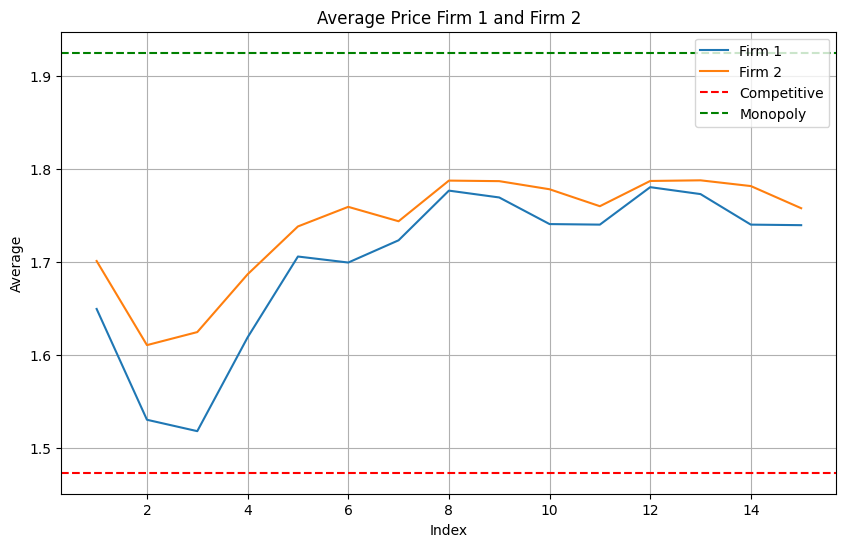

In [28]:
import matplotlib.pyplot as plt

def adjust_block_length(blocks):
    adjusted_blocks = []
    for block in blocks:
        if len(block) < 15:
            # Extend the block with consecutive numbers if it's shorter than 15 elements
            last_element = block[-1]
            extension = list(range(last_element + 1, last_element + 15 - len(block) + 1))
            adjusted_block = block + extension
        elif len(block) > 15:
            # Truncate the block if it's longer than 15 elements
            adjusted_block = block[:15]
        else:
            # Leave the block unchanged if it's already of length 15
            adjusted_block = block
        adjusted_blocks.append(adjusted_block)
    return adjusted_blocks

def plot_index_blocks(df, index_list, column_names):
    index_blocks = []
    current_block = [index_list[0]]
    
    # Find blocks of indices where there is a "jump"
    for i in range(1, len(index_list)):
        if index_list[i] != index_list[i-1] + 1:
            index_blocks.append(current_block)
            current_block = [index_list[i]]
        else:
            current_block.append(index_list[i])
    
    index_blocks.append(current_block)
    adjusted_block = adjust_block_length(index_blocks)

    averages_firm_1 = []
    averages_firm_2 = []

    # Loop through each index (i = 0 to 14)
    for i in range(15):
        # Extract the ith element from each sublist and calculate the average for firm_1 and firm_2
        sublist_indices = [sublist[i] for sublist in adjusted_block]
        avg_firm_1 = df_price_history.loc[sublist_indices, 'firm_1'].mean()
        avg_firm_2 = df_price_history.loc[sublist_indices, 'firm_2'].mean()
        
        # Append averages to the respective lists
        averages_firm_1.append(avg_firm_1)
        averages_firm_2.append(avg_firm_2)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 16), averages_firm_1, label='Firm 1')
    plt.plot(range(1, 16), averages_firm_2, label='Firm 2')
    competitive_constant, monopoly_constant = game.p_minmax
    plt.axhline(y=competitive_constant[0], color='r', linestyle='--', label='Competitive')
    plt.axhline(y=monopoly_constant[0], color='g', linestyle='--', label='Monopoly')
    plt.xlabel('Index')
    plt.ylabel('Average')
    plt.title('Average Price Firm 1 and Firm 2')
    plt.legend()
    plt.grid(True)  
    plt.show()  
        

# Example usage
plot_index_blocks(df_price_history, df_price_history_filtered.index, ['firm_1', 'firm_2'])


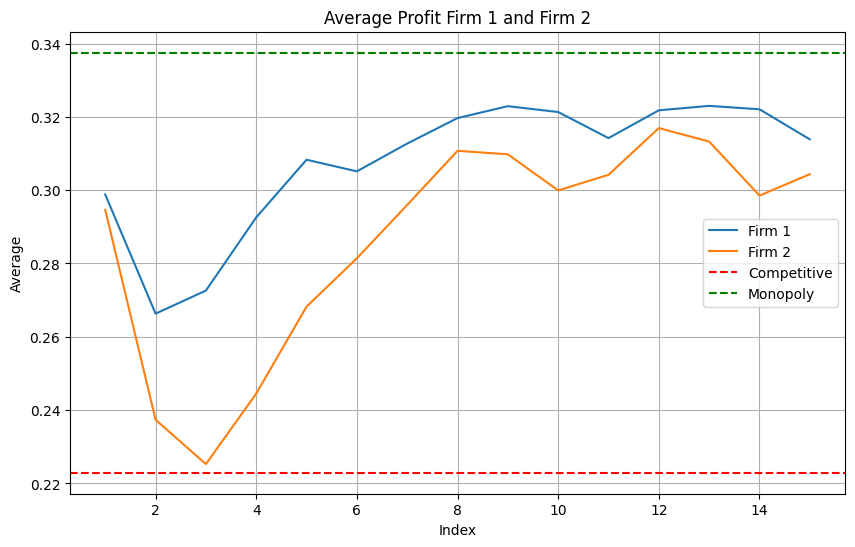

In [29]:
import matplotlib.pyplot as plt

def adjust_block_length(blocks):
    adjusted_blocks = []
    for block in blocks:
        if len(block) < 15:
            # Extend the block with consecutive numbers if it's shorter than 15 elements
            last_element = block[-1]
            extension = list(range(last_element + 1, last_element + 15 - len(block) + 1))
            adjusted_block = block + extension
        elif len(block) > 15:
            # Truncate the block if it's longer than 15 elements
            adjusted_block = block[:15]
        else:
            # Leave the block unchanged if it's already of length 15
            adjusted_block = block
        adjusted_blocks.append(adjusted_block)
    return adjusted_blocks

def plot_index_block_1(df, index_list):
    index_blocks = []
    current_block = [index_list[0]]
    
    # Find blocks of indices where there is a "jump"
    for i in range(1, len(index_list)):
        if index_list[i] != index_list[i-1] + 1:
            index_blocks.append(current_block)
            current_block = [index_list[i]]
        else:
            current_block.append(index_list[i])
    
    index_blocks.append(current_block)
    adjusted_block = adjust_block_length(index_blocks)

    averages_firm_1 = []
    averages_firm_2 = []

    # Loop through each index (i = 0 to 14)
    for i in range(15):
        # Extract the ith element from each sublist and calculate the average for firm_1 and firm_2
        sublist_indices = [sublist[i] for sublist in adjusted_block]
        avg_firm_1 = df.loc[sublist_indices, 'firm_1'].mean()
        avg_firm_2 = df.loc[sublist_indices, 'firm_2'].mean()
        
        # Append averages to the respective lists
        averages_firm_1.append(avg_firm_1)
        averages_firm_2.append(avg_firm_2)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 16), averages_firm_1, label='Firm 1')
    plt.plot(range(1, 16), averages_firm_2, label='Firm 2')
    competitive_constant, monopoly_constant = game.p_minmax
    compettive_profit = game.compute_profits(competitive_constant)[0]
    monopoly_profit = game.compute_profits(monopoly_constant)[0]
    plt.axhline(y=compettive_profit, color='r', linestyle='--', label='Competitive')
    plt.axhline(y=monopoly_profit, color='g', linestyle='--', label='Monopoly')
    plt.xlabel('Index')
    plt.ylabel('Average')
    plt.title('Average Profit Firm 1 and Firm 2')
    plt.legend()
    plt.grid(True)  
    plt.show()  
        

# Example usage
plot_index_block_1(df_profit_history, df_profit_history_filtered.index)


In [30]:
import matplotlib.pyplot as plt

def plot_index_blocks(df, index_list, column_names):
    index_blocks = []
    current_block = [index_list[0]-2]
    
    # Find blocks of indices where there is a "jump"
    for i in range(1, len(index_list)):
        if index_list[i] != index_list[i-1] + 1:
            index_blocks.append(current_block)
            current_block = [index_list[i]-2]
        else:
            current_block.append(index_list[i]-2)
    
    index_blocks.append(current_block)
    adjusted_block = adjust_block_length(index_blocks)
    competitive_constant, monopoly_constant = game.p_minmax
    compettive_profit = game.compute_profits(competitive_constant)[0]
    monopoly_profit = game.compute_profits(monopoly_constant)[0]
    
    # Plot line plots for each block
    for block in reversed(adjusted_block):
        print(df.loc[block, column_names])
        plt.figure()
        for column_name in column_names:
            plt.plot(df.loc[block, column_name], label=column_name)
        plt.axhline(y=compettive_profit, color='r', linestyle='--', label='Competitive')
        plt.axhline(y=monopoly_profit, color='g', linestyle='--', label='Monopoly')
        plt.title(f'Deviation Block')
        plt.xlabel('Index')
        plt.ylabel('Profit')
        plt.legend()
        plt.show()




         firm_1    firm_2
99807  1.811967  1.811967
99808  1.811967  1.811967
99809  1.849639  1.811967
99810  1.435255  1.585940
99811  1.623611  1.435255
99812  1.472927  1.774296
99813  1.510598  1.585940
99814  1.811967  1.811967
99815  1.811967  1.811967
99816  1.811967  1.811967
99817  1.811967  1.811967
99818  1.811967  1.811967
99819  1.811967  1.811967
99820  1.811967  1.811967
99821  1.811967  1.811967


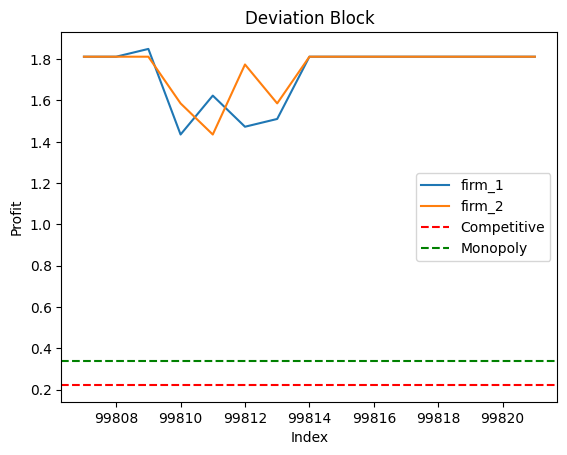

         firm_1    firm_2
99337  1.811967  1.811967
99338  1.811967  1.849639
99339  1.510598  1.510598
99340  1.623611  1.435255
99341  1.472927  1.774296
99342  1.510598  1.585940
99343  1.811967  1.811967
99344  1.811967  1.811967
99345  1.811967  1.811967
99346  1.811967  1.811967
99347  1.811967  1.811967
99348  1.811967  1.811967
99349  1.811967  1.811967
99350  1.811967  1.811967
99351  1.811967  1.811967


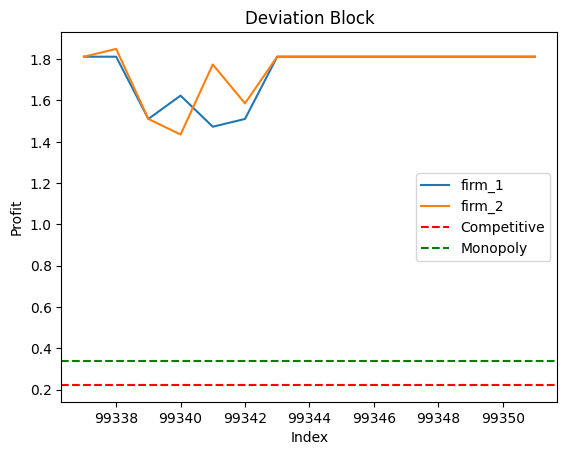

         firm_1    firm_2
98829  1.811967  1.811967
98830  1.811967  1.548269
98831  1.623611  1.472927
98832  1.623611  1.435255
98833  1.472927  1.774296
98834  1.510598  1.585940
98835  1.811967  1.811967
98836  1.811967  1.811967
98837  1.811967  1.811967
98838  1.811967  1.811967
98839  1.811967  1.811967
98840  1.811967  1.811967
98841  1.811967  1.811967
98842  1.811967  1.811967
98843  1.811967  1.811967


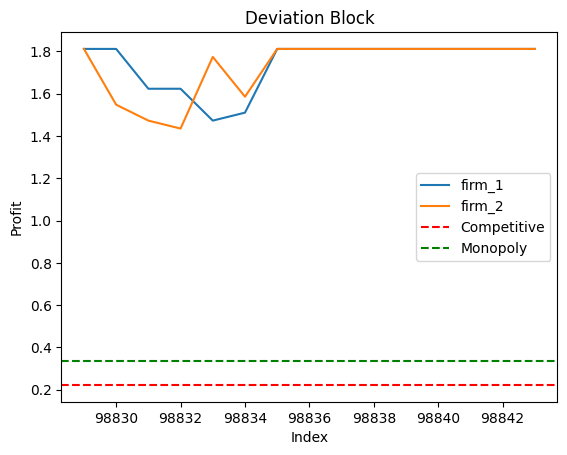

         firm_1    firm_2
98471  1.811967  1.811967
98472  1.811967  1.472927
98473  1.435255  1.472927
98474  1.472927  1.623611
98475  1.623611  1.623611
98476  1.623611  1.472927
98477  1.623611  1.435255
98478  1.472927  1.774296
98479  1.510598  1.585940
98480  1.811967  1.811967
98481  1.811967  1.811967
98482  1.811967  1.811967
98483  1.811967  1.811967
98484  1.811967  1.811967
98485  1.811967  1.811967


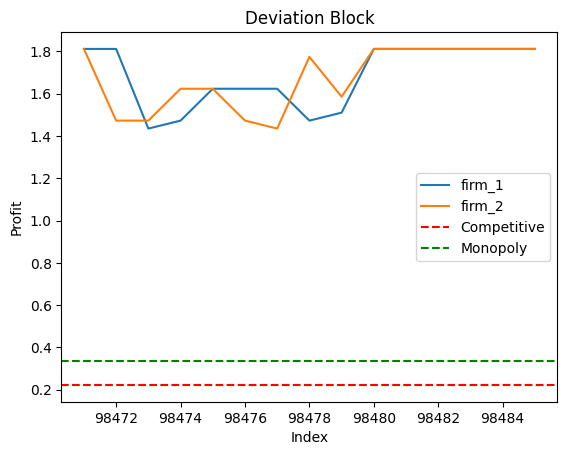

         firm_1    firm_2
98417  1.811967  1.811967
98418  1.811967  1.472927
98419  1.435255  1.472927
98420  1.472927  1.623611
98421  1.623611  1.623611
98422  1.623611  1.472927
98423  1.623611  1.435255
98424  1.472927  1.774296
98425  1.510598  1.585940
98426  1.811967  1.811967
98427  1.811967  1.811967
98428  1.811967  1.811967
98429  1.811967  1.811967
98430  1.811967  1.811967
98431  1.811967  1.811967


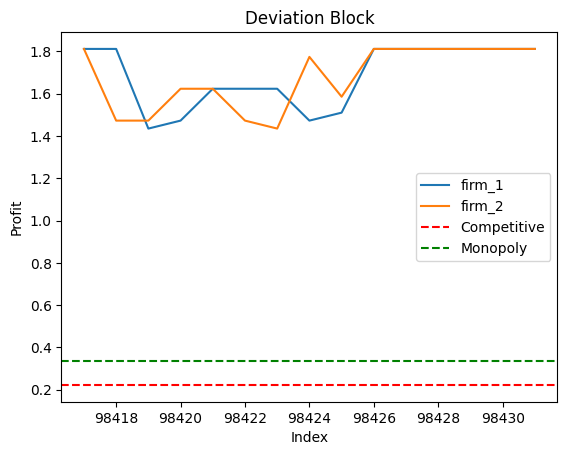

         firm_1    firm_2
98151  1.811967  1.811967
98152  1.811967  1.811967
98153  1.698954  1.811967
98154  1.472927  1.510598
98155  1.472927  1.774296
98156  1.510598  1.585940
98157  1.811967  1.811967
98158  1.811967  1.811967
98159  1.811967  1.811967
98160  1.811967  1.811967
98161  1.811967  1.811967
98162  1.811967  1.811967
98163  1.811967  1.811967
98164  1.811967  1.811967
98165  1.811967  1.811967


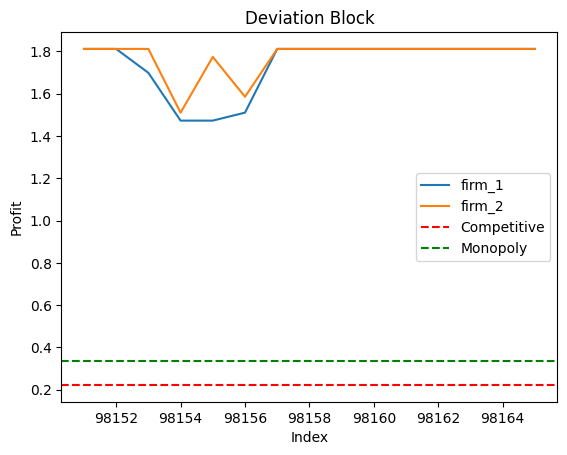

         firm_1    firm_2
97689  1.811967  1.811967
97690  1.811967  1.811967
97691  1.472927  1.811967
97692  1.472927  1.472927
97693  1.472927  1.774296
97694  1.510598  1.585940
97695  1.811967  1.811967
97696  1.811967  1.811967
97697  1.811967  1.811967
97698  1.811967  1.811967
97699  1.811967  1.811967
97700  1.811967  1.811967
97701  1.811967  1.811967
97702  1.811967  1.811967
97703  1.811967  1.811967


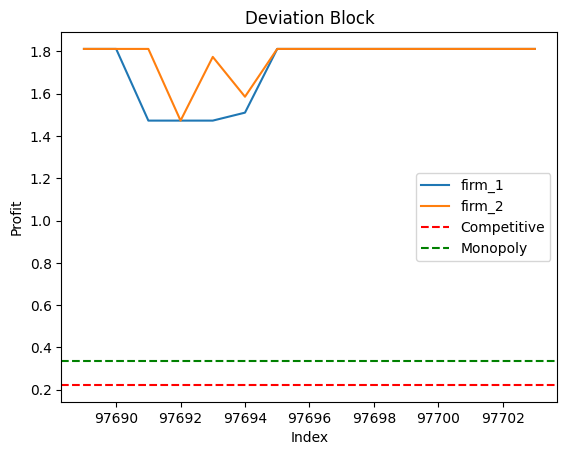

         firm_1    firm_2
97605  1.811967  1.811967
97606  1.811967  1.774296
97607  1.623611  1.435255
97608  1.472927  1.774296
97609  1.510598  1.585940
97610  1.811967  1.811967
97611  1.811967  1.811967
97612  1.811967  1.811967
97613  1.811967  1.811967
97614  1.811967  1.811967
97615  1.811967  1.811967
97616  1.811967  1.811967
97617  1.811967  1.811967
97618  1.811967  1.811967
97619  1.811967  1.811967


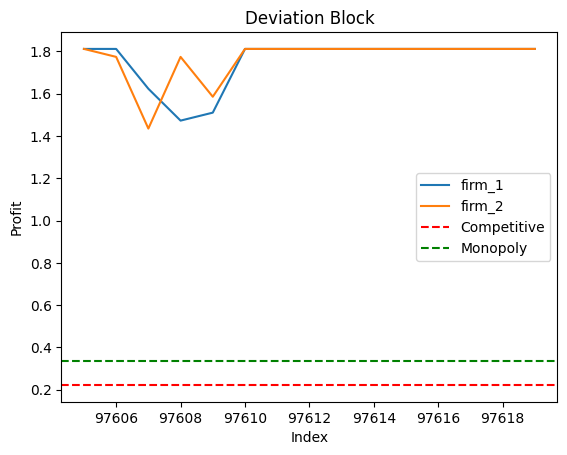

         firm_1    firm_2
97438  1.811967  1.811967
97439  1.811967  1.811967
97440  1.849639  1.811967
97441  1.435255  1.585940
97442  1.623611  1.435255
97443  1.472927  1.774296
97444  1.510598  1.585940
97445  1.811967  1.811967
97446  1.811967  1.811967
97447  1.811967  1.811967
97448  1.811967  1.811967
97449  1.811967  1.811967
97450  1.811967  1.811967
97451  1.811967  1.811967
97452  1.811967  1.811967


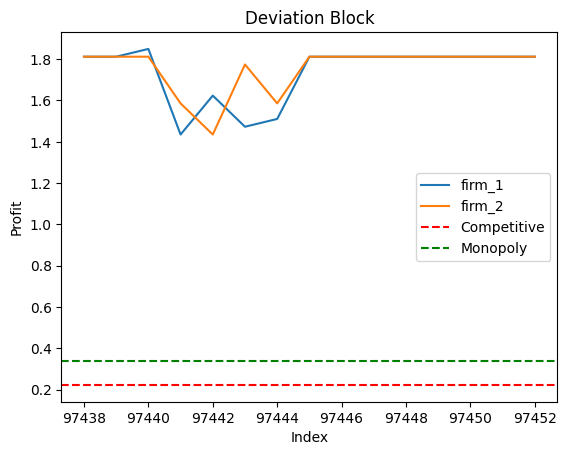

         firm_1    firm_2
97194  1.811967  1.811967
97195  1.811967  1.811967
97196  1.623611  1.811967
97197  1.472927  1.472927
97198  1.472927  1.774296
97199  1.510598  1.585940
97200  1.811967  1.811967
97201  1.811967  1.811967
97202  1.811967  1.811967
97203  1.811967  1.811967
97204  1.811967  1.811967
97205  1.811967  1.811967
97206  1.811967  1.811967
97207  1.811967  1.811967
97208  1.811967  1.811967


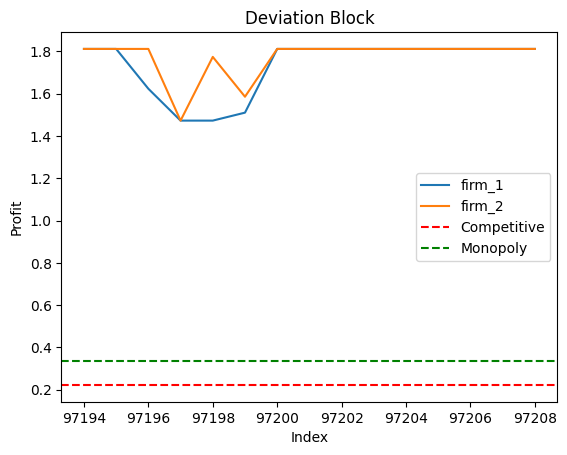

         firm_1    firm_2
96499  1.811967  1.811967
96500  1.811967  1.811967
96501  1.924981  1.811967
96502  1.472927  1.472927
96503  1.472927  1.774296
96504  1.510598  1.585940
96505  1.811967  1.811967
96506  1.811967  1.811967
96507  1.811967  1.811967
96508  1.811967  1.811967
96509  1.811967  1.811967
96510  1.811967  1.811967
96511  1.811967  1.811967
96512  1.811967  1.811967
96513  1.811967  1.811967


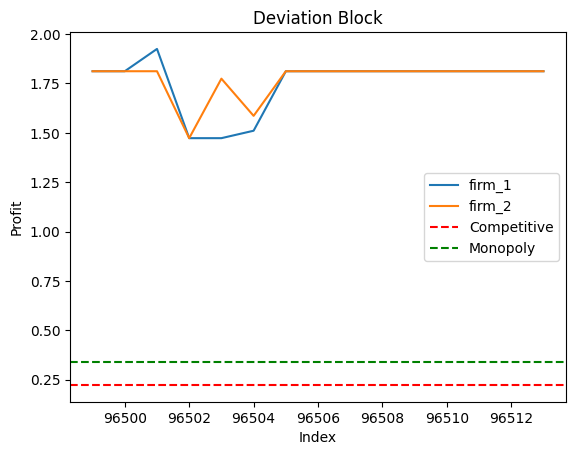

         firm_1    firm_2
94575  1.811967  1.811967
94576  1.811967  1.472927
94577  1.435255  1.472927
94578  1.472927  1.623611
94579  1.623611  1.623611
94580  1.623611  1.472927
94581  1.623611  1.435255
94582  1.472927  1.774296
94583  1.510598  1.585940
94584  1.811967  1.811967
94585  1.811967  1.811967
94586  1.811967  1.811967
94587  1.811967  1.811967
94588  1.811967  1.811967
94589  1.811967  1.811967


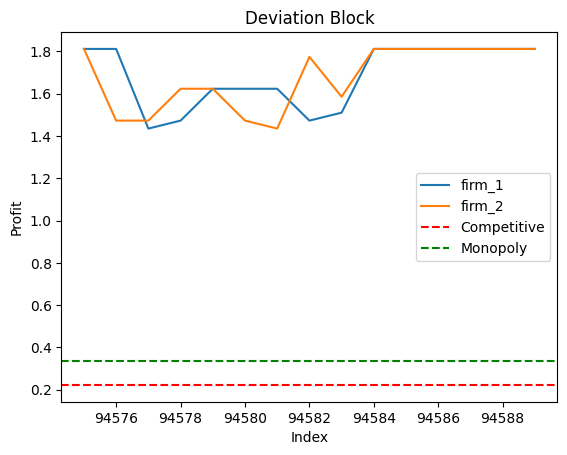

         firm_1    firm_2
94290  1.811967  1.811967
94291  1.811967  1.811967
94292  1.472927  1.811967
94293  1.472927  1.472927
94294  1.472927  1.774296
94295  1.510598  1.585940
94296  1.811967  1.811967
94297  1.811967  1.811967
94298  1.811967  1.811967
94299  1.811967  1.811967
94300  1.811967  1.811967
94301  1.811967  1.811967
94302  1.811967  1.811967
94303  1.811967  1.811967
94304  1.811967  1.811967


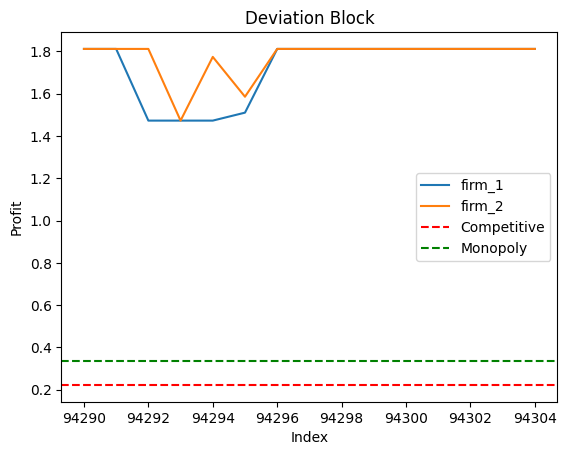

         firm_1    firm_2
94272  1.811967  1.811967
94273  1.811967  1.811967
94274  1.548269  1.811967
94275  1.623611  1.623611
94276  1.623611  1.472927
94277  1.623611  1.435255
94278  1.472927  1.774296
94279  1.510598  1.585940
94280  1.811967  1.811967
94281  1.811967  1.811967
94282  1.811967  1.811967
94283  1.811967  1.811967
94284  1.811967  1.811967
94285  1.811967  1.811967
94286  1.811967  1.811967


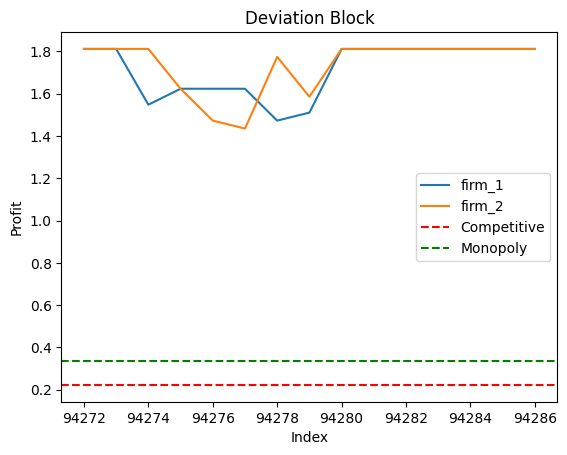

         firm_1    firm_2
93922  1.811967  1.811967
93923  1.811967  1.811967
93924  1.548269  1.811967
93925  1.623611  1.623611
93926  1.623611  1.472927
93927  1.623611  1.435255
93928  1.472927  1.774296
93929  1.510598  1.585940
93930  1.811967  1.811967
93931  1.811967  1.811967
93932  1.811967  1.811967
93933  1.811967  1.811967
93934  1.811967  1.811967
93935  1.811967  1.811967
93936  1.811967  1.811967


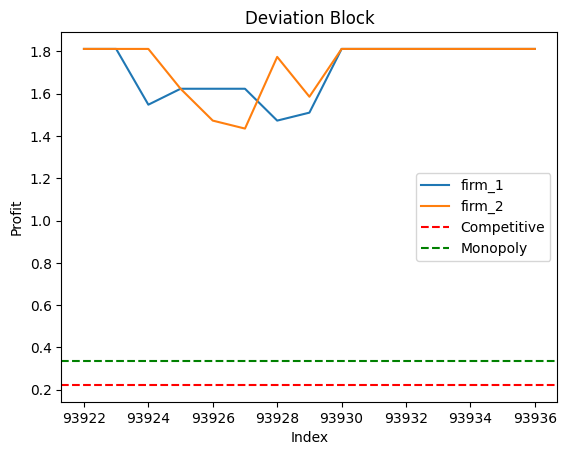

         firm_1    firm_2
93726  1.811967  1.811967
93727  1.811967  1.698954
93728  1.698954  1.661283
93729  1.698954  1.623611
93730  1.472927  1.510598
93731  1.472927  1.774296
93732  1.510598  1.585940
93733  1.811967  1.811967
93734  1.811967  1.811967
93735  1.811967  1.811967
93736  1.811967  1.811967
93737  1.811967  1.811967
93738  1.811967  1.811967
93739  1.811967  1.811967
93740  1.811967  1.811967


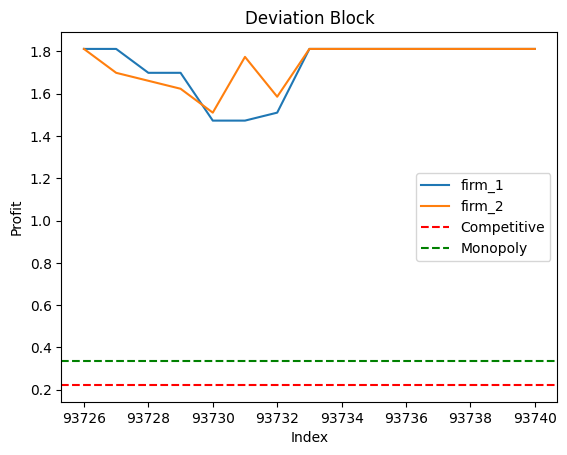

         firm_1    firm_2
93516  1.811967  1.811967
93517  1.811967  1.472927
93518  1.435255  1.472927
93519  1.472927  1.623611
93520  1.623611  1.623611
93521  1.623611  1.472927
93522  1.623611  1.435255
93523  1.472927  1.774296
93524  1.510598  1.585940
93525  1.811967  1.811967
93526  1.811967  1.811967
93527  1.811967  1.811967
93528  1.811967  1.811967
93529  1.811967  1.811967
93530  1.811967  1.811967


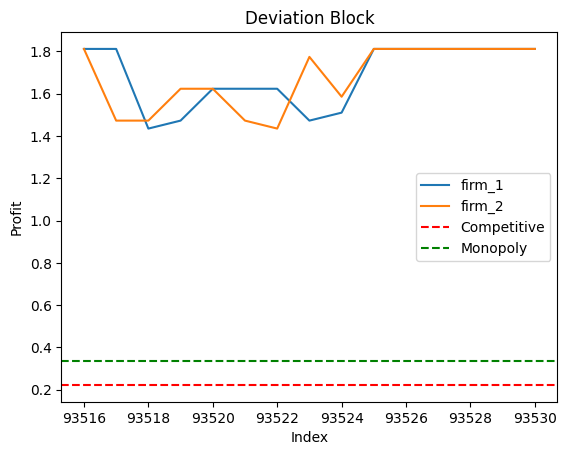

         firm_1    firm_2
93372  1.811967  1.811967
93373  1.811967  1.811967
93374  1.698954  1.811967
93375  1.472927  1.510598
93376  1.472927  1.774296
93377  1.510598  1.585940
93378  1.811967  1.811967
93379  1.811967  1.811967
93380  1.811967  1.811967
93381  1.811967  1.811967
93382  1.811967  1.811967
93383  1.811967  1.811967
93384  1.811967  1.811967
93385  1.811967  1.811967
93386  1.811967  1.811967


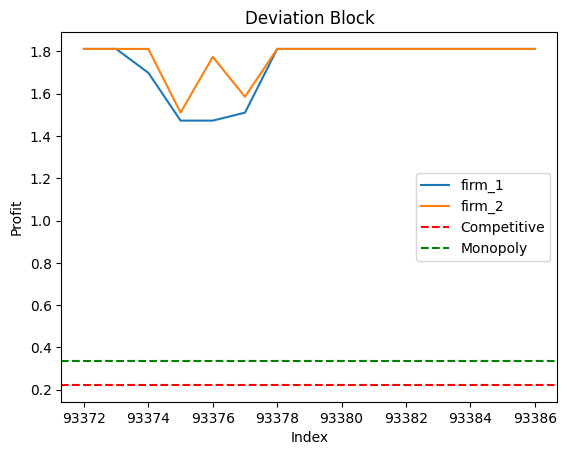

         firm_1    firm_2
93312  1.811967  1.811967
93313  1.811967  1.811967
93314  1.472927  1.811967
93315  1.472927  1.472927
93316  1.472927  1.774296
93317  1.510598  1.585940
93318  1.811967  1.811967
93319  1.811967  1.811967
93320  1.811967  1.811967
93321  1.811967  1.811967
93322  1.811967  1.811967
93323  1.811967  1.811967
93324  1.811967  1.811967
93325  1.811967  1.811967
93326  1.811967  1.811967


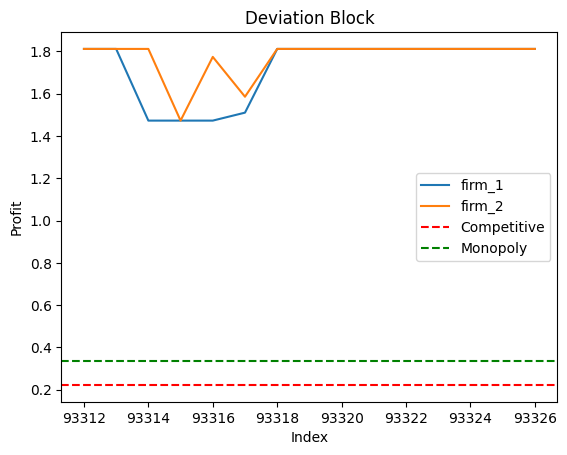

         firm_1    firm_2
93282  1.811967  1.811967
93283  1.811967  1.924981
93284  1.435255  1.472927
93285  1.472927  1.623611
93286  1.623611  1.623611
93287  1.623611  1.472927
93288  1.623611  1.435255
93289  1.472927  1.774296
93290  1.510598  1.585940
93291  1.811967  1.811967
93292  1.811967  1.811967
93293  1.811967  1.811967
93294  1.811967  1.811967
93295  1.811967  1.811967
93296  1.811967  1.811967


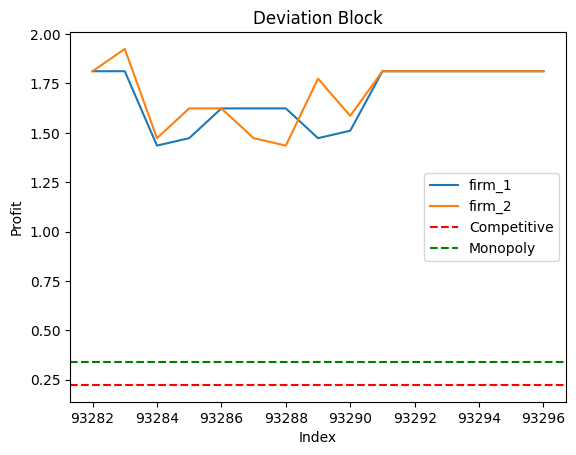

         firm_1    firm_2
92405  1.811967  1.811967
92406  1.811967  1.698954
92407  1.698954  1.661283
92408  1.698954  1.623611
92409  1.472927  1.510598
92410  1.472927  1.774296
92411  1.510598  1.585940
92412  1.811967  1.811967
92413  1.811967  1.811967
92414  1.811967  1.811967
92415  1.811967  1.811967
92416  1.811967  1.811967
92417  1.811967  1.811967
92418  1.811967  1.811967
92419  1.811967  1.811967


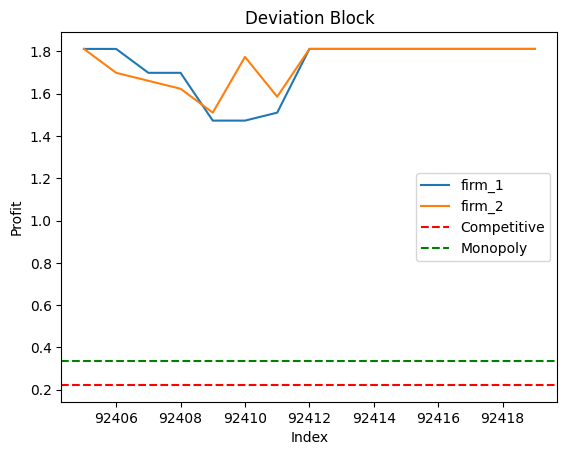

         firm_1    firm_2
91764  1.811967  1.811967
91765  1.811967  1.811967
91766  1.472927  1.811967
91767  1.472927  1.472927
91768  1.472927  1.774296
91769  1.510598  1.585940
91770  1.811967  1.811967
91771  1.811967  1.811967
91772  1.811967  1.811967
91773  1.811967  1.811967
91774  1.811967  1.811967
91775  1.811967  1.811967
91776  1.811967  1.811967
91777  1.811967  1.811967
91778  1.811967  1.811967


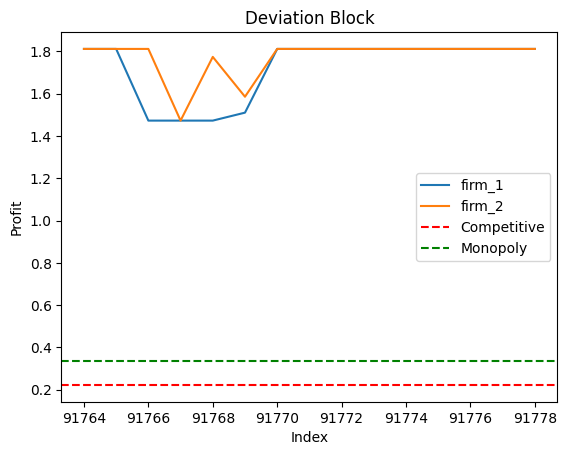

         firm_1    firm_2
91528  1.811967  1.811967
91529  1.811967  1.585940
91530  1.661283  1.661283
91531  1.472927  1.510598
91532  1.472927  1.774296
91533  1.510598  1.585940
91534  1.811967  1.811967
91535  1.811967  1.811967
91536  1.811967  1.811967
91537  1.811967  1.811967
91538  1.811967  1.811967
91539  1.811967  1.811967
91540  1.811967  1.811967
91541  1.811967  1.811967
91542  1.811967  1.811967


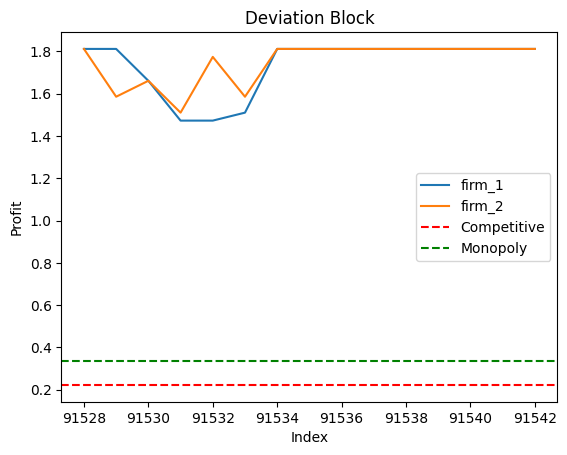

         firm_1    firm_2
90474  1.811967  1.811967
90475  1.811967  1.811967
90476  1.962652  1.811967
90477  1.472927  1.774296
90478  1.510598  1.585940
90479  1.811967  1.811967
90480  1.811967  1.811967
90481  1.811967  1.811967
90482  1.811967  1.811967
90483  1.811967  1.811967
90484  1.811967  1.811967
90485  1.811967  1.811967
90486  1.811967  1.811967
90487  1.811967  1.811967
90488  1.811967  1.811967


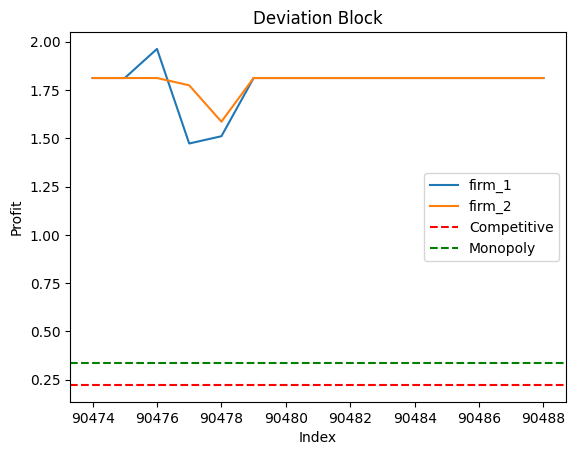

         firm_1    firm_2
90181  1.811967  1.811967
90182  1.811967  1.811967
90183  1.435255  1.811967
90184  1.623611  1.548269
90185  1.548269  1.623611
90186  1.585940  1.774296
90187  1.661283  1.698954
90188  1.510598  1.585940
90189  1.811967  1.811967
90190  1.811967  1.811967
90191  1.811967  1.811967
90192  1.811967  1.811967
90193  1.811967  1.811967
90194  1.811967  1.811967
90195  1.811967  1.811967


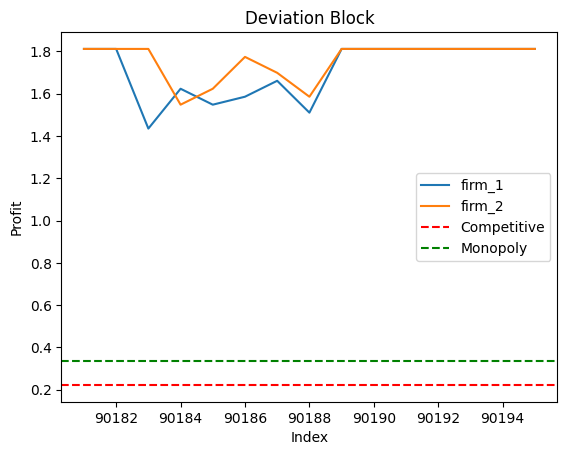

         firm_1    firm_2
90040  1.811967  1.811967
90041  1.811967  1.472927
90042  1.435255  1.472927
90043  1.472927  1.623611
90044  1.623611  1.623611
90045  1.623611  1.472927
90046  1.623611  1.435255
90047  1.472927  1.774296
90048  1.510598  1.585940
90049  1.811967  1.811967
90050  1.811967  1.811967
90051  1.811967  1.811967
90052  1.811967  1.811967
90053  1.811967  1.811967
90054  1.811967  1.811967


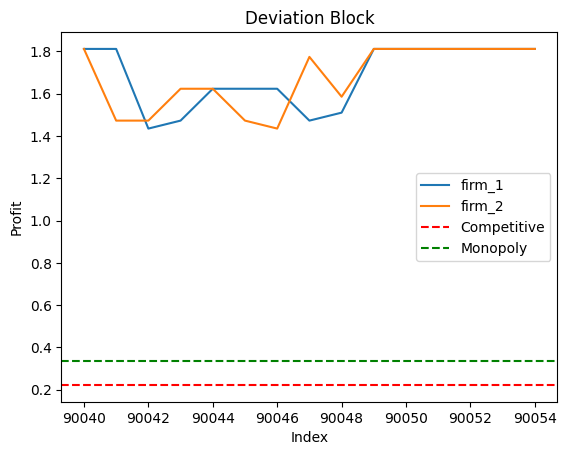

         firm_1    firm_2
89710  1.811967  1.811967
89711  1.811967  1.811967
89712  1.435255  1.811967
89713  1.623611  1.548269
89714  1.548269  1.623611
89715  1.585940  1.774296
89716  1.661283  1.698954
89717  1.510598  1.585940
89718  1.811967  1.811967
89719  1.811967  1.811967
89720  1.811967  1.811967
89721  1.811967  1.811967
89722  1.811967  1.811967
89723  1.811967  1.811967
89724  1.811967  1.811967


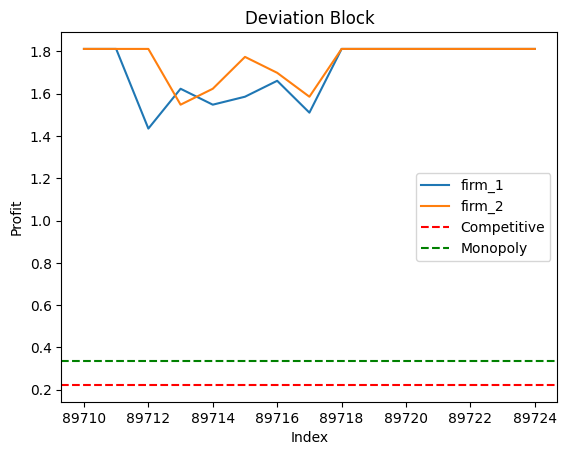

         firm_1    firm_2
89270  1.811967  1.811967
89271  1.811967  1.887310
89272  1.623611  1.623611
89273  1.623611  1.472927
89274  1.623611  1.435255
89275  1.472927  1.774296
89276  1.510598  1.585940
89277  1.811967  1.811967
89278  1.811967  1.811967
89279  1.811967  1.811967
89280  1.811967  1.811967
89281  1.811967  1.811967
89282  1.811967  1.811967
89283  1.811967  1.811967
89284  1.811967  1.811967


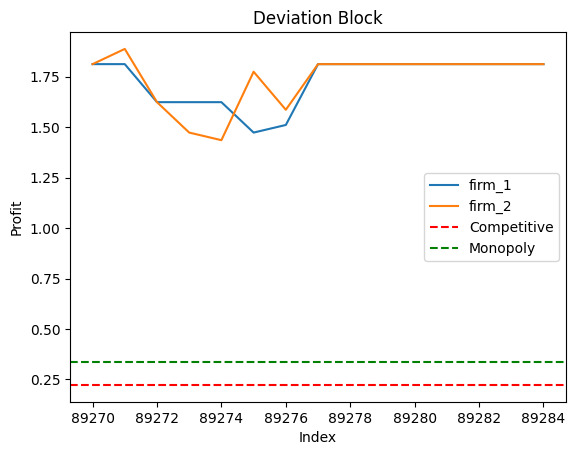

         firm_1    firm_2
88561  1.811967  1.811967
88562  1.811967  1.811967
88563  1.698954  1.811967
88564  1.472927  1.510598
88565  1.472927  1.774296
88566  1.510598  1.585940
88567  1.811967  1.811967
88568  1.811967  1.811967
88569  1.811967  1.811967
88570  1.811967  1.811967
88571  1.811967  1.811967
88572  1.811967  1.811967
88573  1.811967  1.811967
88574  1.811967  1.811967
88575  1.811967  1.811967


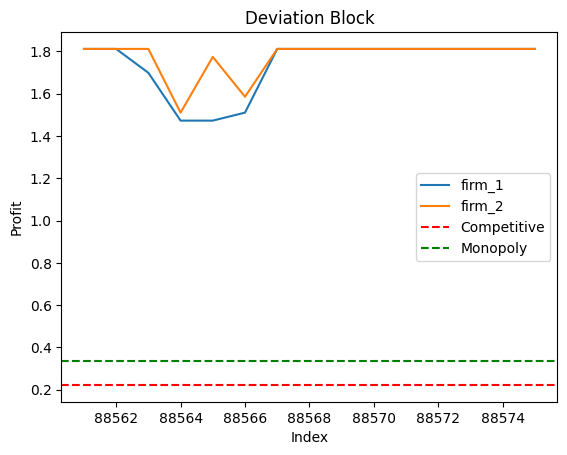

         firm_1    firm_2
88366  1.811967  1.811967
88367  1.811967  1.736625
88368  1.548269  1.623611
88369  1.585940  1.774296
88370  1.661283  1.698954
88371  1.510598  1.585940
88372  1.811967  1.811967
88373  1.811967  1.811967
88374  1.811967  1.811967
88375  1.811967  1.811967
88376  1.811967  1.811967
88377  1.811967  1.811967
88378  1.811967  1.811967
88379  1.811967  1.811967
88380  1.811967  1.811967


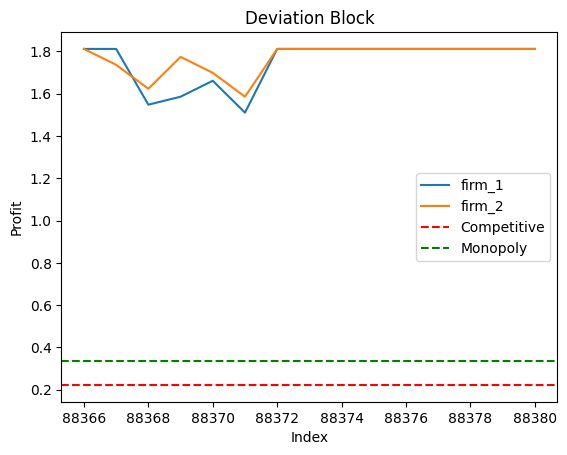

         firm_1    firm_2
88111  1.811967  1.811967
88112  1.811967  1.585940
88113  1.661283  1.661283
88114  1.472927  1.510598
88115  1.472927  1.774296
88116  1.510598  1.585940
88117  1.811967  1.811967
88118  1.811967  1.811967
88119  1.811967  1.811967
88120  1.811967  1.811967
88121  1.811967  1.811967
88122  1.811967  1.811967
88123  1.811967  1.811967
88124  1.811967  1.811967
88125  1.811967  1.811967


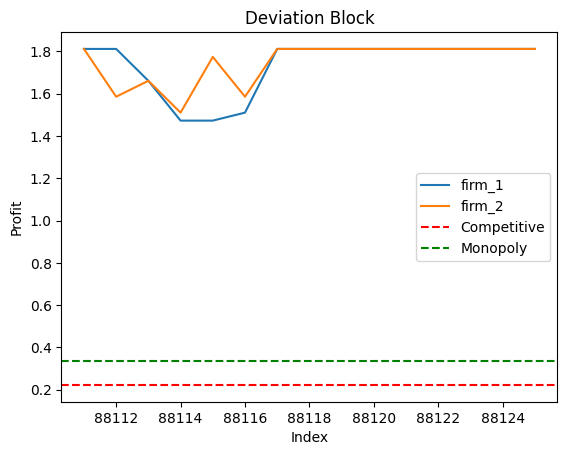

         firm_1    firm_2
87970  1.811967  1.811967
87971  1.811967  1.736625
87972  1.548269  1.623611
87973  1.585940  1.774296
87974  1.661283  1.698954
87975  1.510598  1.585940
87976  1.811967  1.811967
87977  1.811967  1.811967
87978  1.811967  1.811967
87979  1.811967  1.811967
87980  1.811967  1.811967
87981  1.811967  1.811967
87982  1.811967  1.811967
87983  1.811967  1.811967
87984  1.811967  1.811967


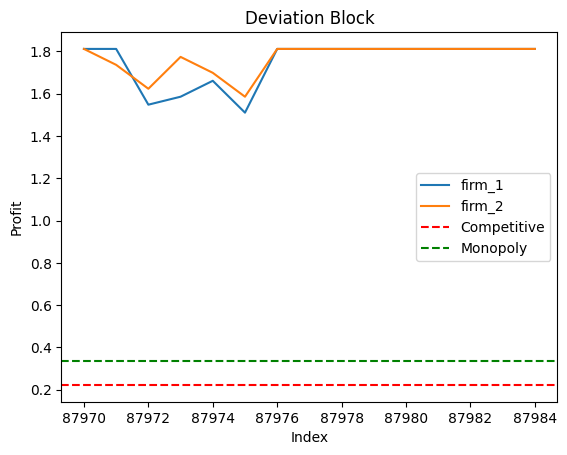

         firm_1    firm_2
87520  1.811967  1.811967
87521  1.811967  1.623611
87522  1.472927  1.472927
87523  1.472927  1.774296
87524  1.510598  1.585940
87525  1.811967  1.811967
87526  1.811967  1.811967
87527  1.811967  1.811967
87528  1.811967  1.811967
87529  1.811967  1.811967
87530  1.811967  1.811967
87531  1.811967  1.811967
87532  1.811967  1.811967
87533  1.811967  1.811967
87534  1.811967  1.811967


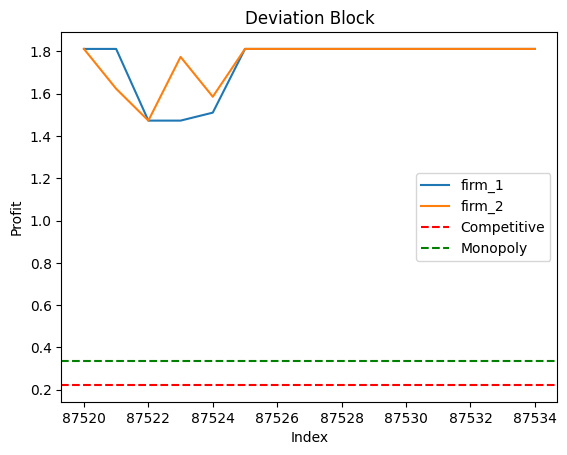

         firm_1    firm_2
86841  1.811967  1.811967
86842  1.811967  1.811967
86843  1.774296  1.811967
86844  1.585940  1.472927
86845  1.548269  1.472927
86846  1.472927  1.472927
86847  1.472927  1.774296
86848  1.510598  1.585940
86849  1.811967  1.811967
86850  1.811967  1.811967
86851  1.811967  1.811967
86852  1.811967  1.811967
86853  1.811967  1.811967
86854  1.811967  1.811967
86855  1.811967  1.811967


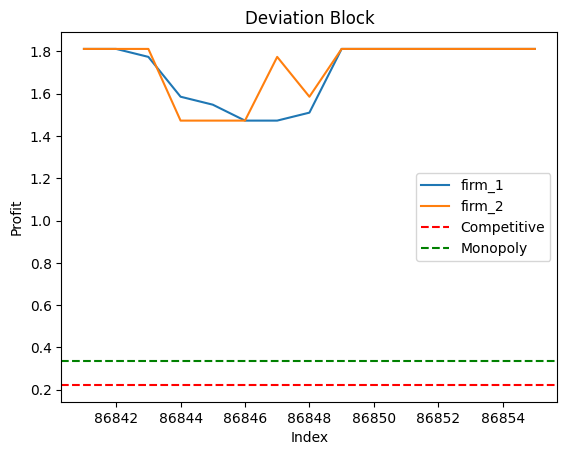

         firm_1    firm_2
86753  1.811967  1.811967
86754  1.811967  1.585940
86755  1.661283  1.661283
86756  1.472927  1.510598
86757  1.472927  1.774296
86758  1.510598  1.585940
86759  1.811967  1.811967
86760  1.811967  1.811967
86761  1.811967  1.811967
86762  1.811967  1.811967
86763  1.811967  1.811967
86764  1.811967  1.811967
86765  1.811967  1.811967
86766  1.811967  1.811967
86767  1.811967  1.811967


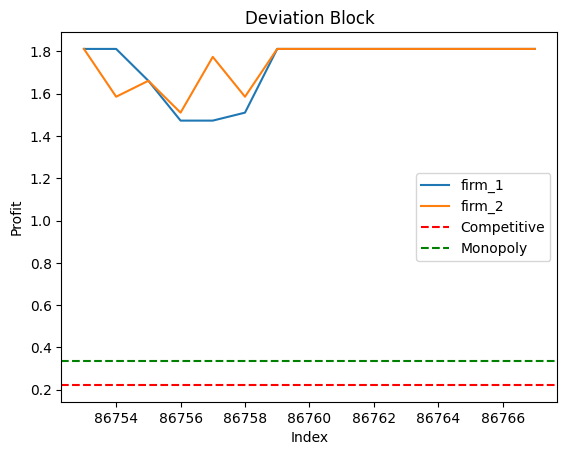

         firm_1    firm_2
86196  1.811967  1.811967
86197  1.811967  1.811967
86198  1.736625  1.811967
86199  1.472927  1.774296
86200  1.510598  1.585940
86201  1.811967  1.811967
86202  1.811967  1.811967
86203  1.811967  1.811967
86204  1.811967  1.811967
86205  1.811967  1.811967
86206  1.811967  1.811967
86207  1.811967  1.811967
86208  1.811967  1.811967
86209  1.811967  1.811967
86210  1.811967  1.811967


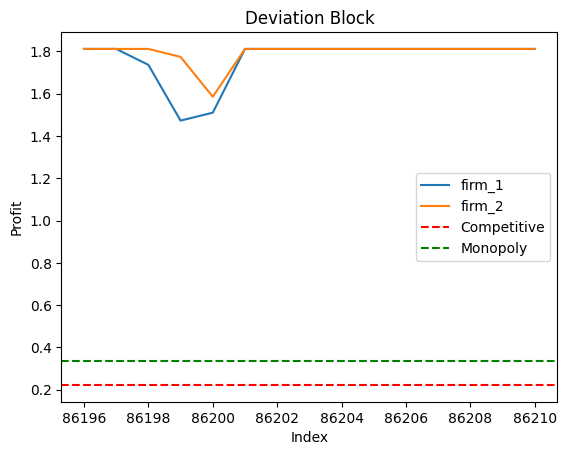

         firm_1    firm_2
86106  1.811967  1.811967
86107  1.811967  1.849639
86108  1.510598  1.510598
86109  1.623611  1.435255
86110  1.472927  1.774296
86111  1.510598  1.585940
86112  1.811967  1.811967
86113  1.811967  1.811967
86114  1.811967  1.811967
86115  1.811967  1.811967
86116  1.811967  1.811967
86117  1.811967  1.811967
86118  1.811967  1.811967
86119  1.811967  1.811967
86120  1.811967  1.811967


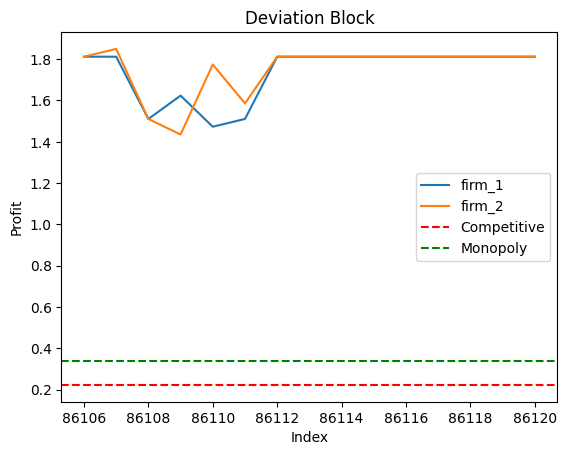

         firm_1    firm_2
85832  1.811967  1.811967
85833  1.811967  1.811967
85834  1.623611  1.811967
85835  1.472927  1.472927
85836  1.472927  1.774296
85837  1.510598  1.585940
85838  1.811967  1.811967
85839  1.811967  1.811967
85840  1.811967  1.811967
85841  1.811967  1.811967
85842  1.811967  1.811967
85843  1.811967  1.811967
85844  1.811967  1.811967
85845  1.811967  1.811967
85846  1.811967  1.811967


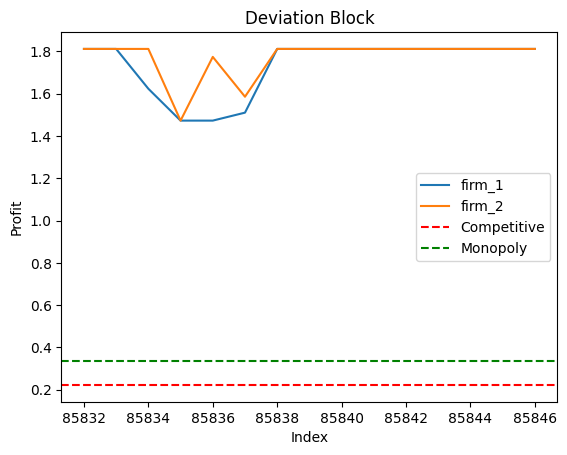

         firm_1    firm_2
85552  1.811967  1.811967
85553  1.811967  1.811967
85554  1.623611  1.811967
85555  1.472927  1.472927
85556  1.472927  1.774296
85557  1.510598  1.585940
85558  1.811967  1.811967
85559  1.811967  1.811967
85560  1.811967  1.811967
85561  1.811967  1.811967
85562  1.811967  1.811967
85563  1.811967  1.811967
85564  1.811967  1.811967
85565  1.811967  1.811967
85566  1.811967  1.811967


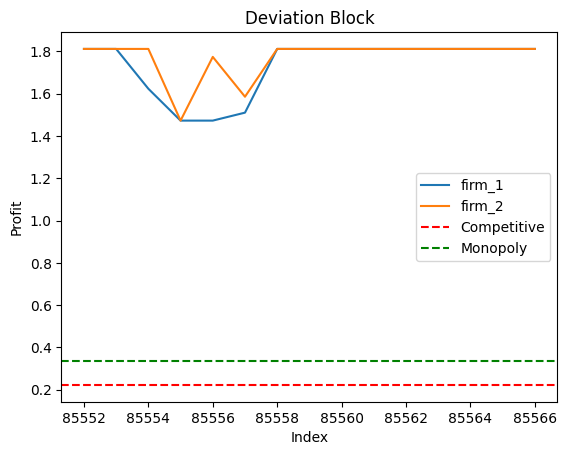

         firm_1    firm_2
85413  1.811967  1.811967
85414  1.811967  1.811967
85415  1.435255  1.811967
85416  1.623611  1.548269
85417  1.548269  1.623611
85418  1.585940  1.774296
85419  1.661283  1.698954
85420  1.510598  1.585940
85421  1.811967  1.811967
85422  1.811967  1.811967
85423  1.811967  1.811967
85424  1.811967  1.811967
85425  1.811967  1.811967
85426  1.811967  1.811967
85427  1.811967  1.811967


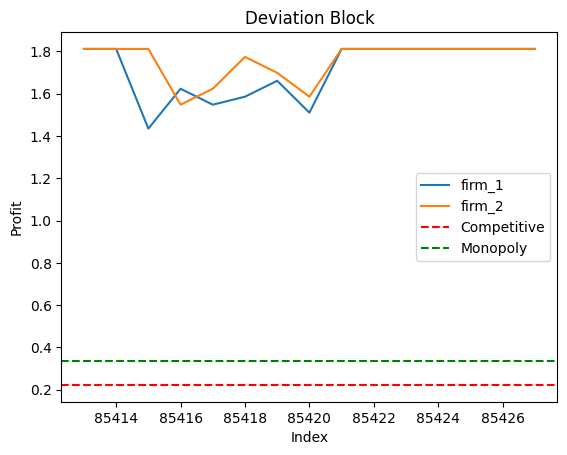

         firm_1    firm_2
85282  1.811967  1.811967
85283  1.811967  1.811967
85284  1.962652  1.811967
85285  1.472927  1.774296
85286  1.510598  1.585940
85287  1.811967  1.811967
85288  1.811967  1.811967
85289  1.811967  1.811967
85290  1.811967  1.811967
85291  1.811967  1.811967
85292  1.811967  1.811967
85293  1.811967  1.811967
85294  1.811967  1.811967
85295  1.811967  1.811967
85296  1.811967  1.811967


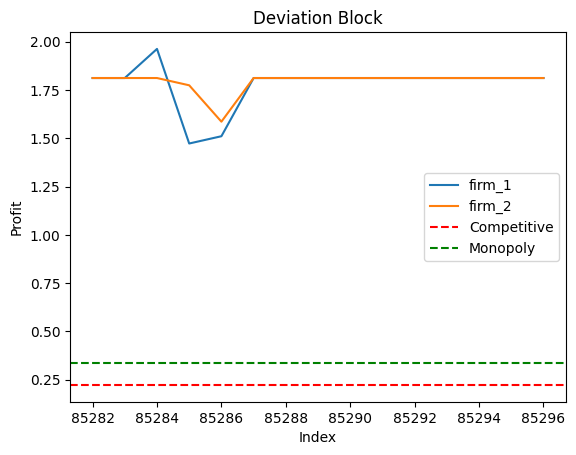

         firm_1    firm_2
85227  1.811967  1.811967
85228  1.811967  1.435255
85229  1.548269  1.472927
85230  1.472927  1.472927
85231  1.472927  1.774296
85232  1.510598  1.585940
85233  1.811967  1.811967
85234  1.811967  1.811967
85235  1.811967  1.811967
85236  1.811967  1.811967
85237  1.811967  1.811967
85238  1.811967  1.811967
85239  1.811967  1.811967
85240  1.811967  1.811967
85241  1.811967  1.811967


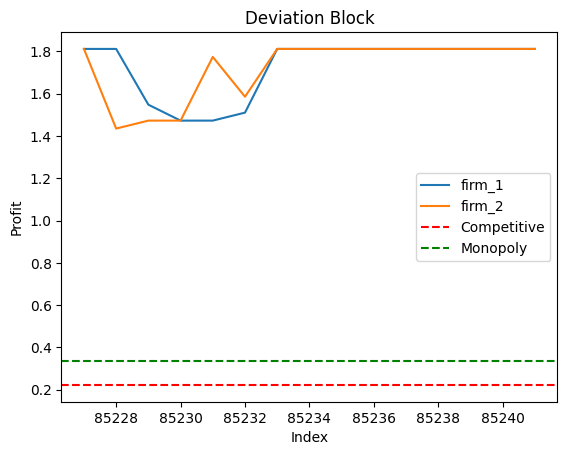

         firm_1    firm_2
84881  1.811967  1.811967
84882  1.811967  1.887310
84883  1.623611  1.623611
84884  1.623611  1.472927
84885  1.623611  1.435255
84886  1.472927  1.774296
84887  1.510598  1.585940
84888  1.811967  1.811967
84889  1.811967  1.811967
84890  1.811967  1.811967
84891  1.811967  1.811967
84892  1.811967  1.811967
84893  1.811967  1.811967
84894  1.811967  1.811967
84895  1.811967  1.811967


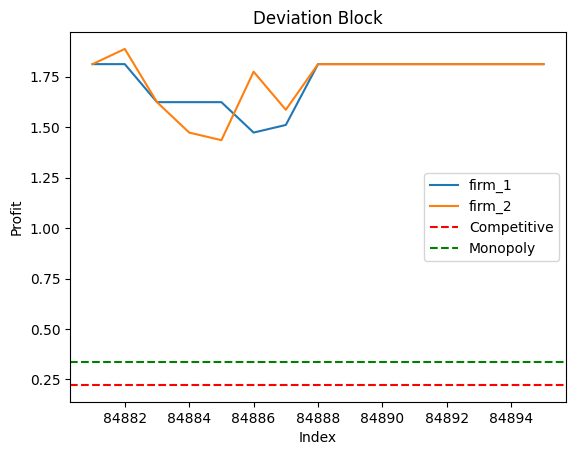

         firm_1    firm_2
83286  1.811967  1.811967
83287  1.811967  1.435255
83288  1.548269  1.472927
83289  1.472927  1.472927
83290  1.472927  1.774296
83291  1.510598  1.585940
83292  1.811967  1.811967
83293  1.811967  1.811967
83294  1.811967  1.811967
83295  1.811967  1.811967
83296  1.811967  1.811967
83297  1.811967  1.811967
83298  1.811967  1.811967
83299  1.811967  1.811967
83300  1.811967  1.811967


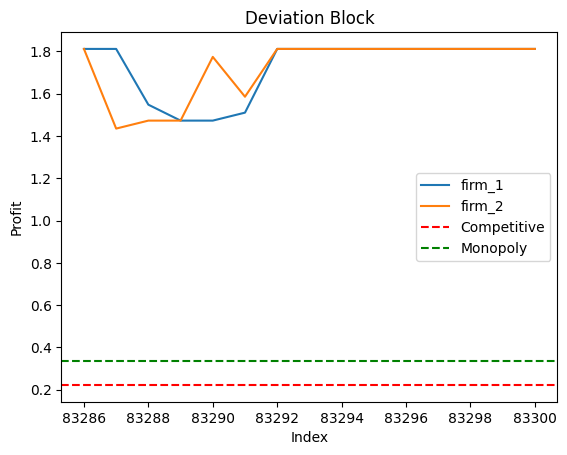

         firm_1    firm_2
82530  1.811967  1.811967
82531  1.811967  1.849639
82532  1.510598  1.510598
82533  1.623611  1.435255
82534  1.472927  1.774296
82535  1.510598  1.585940
82536  1.811967  1.811967
82537  1.811967  1.811967
82538  1.811967  1.811967
82539  1.811967  1.811967
82540  1.811967  1.811967
82541  1.811967  1.811967
82542  1.811967  1.811967
82543  1.811967  1.811967
82544  1.811967  1.811967


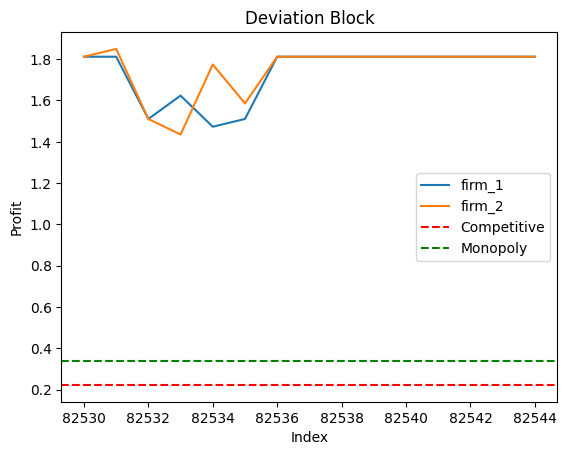

         firm_1    firm_2
81685  1.811967  1.811967
81686  1.811967  1.811967
81687  1.623611  1.811967
81688  1.472927  1.472927
81689  1.472927  1.774296
81690  1.510598  1.585940
81691  1.811967  1.811967
81692  1.811967  1.811967
81693  1.811967  1.811967
81694  1.811967  1.811967
81695  1.811967  1.811967
81696  1.811967  1.811967
81697  1.811967  1.811967
81698  1.811967  1.811967
81699  1.811967  1.811967


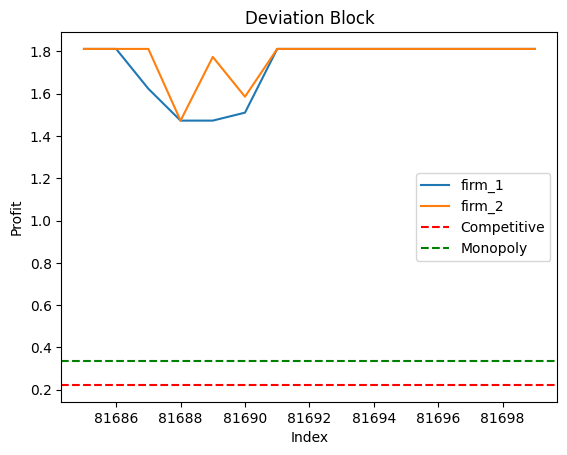

         firm_1    firm_2
81069  1.811967  1.811967
81070  1.811967  1.623611
81071  1.472927  1.472927
81072  1.472927  1.774296
81073  1.510598  1.585940
81074  1.811967  1.811967
81075  1.811967  1.811967
81076  1.811967  1.811967
81077  1.811967  1.811967
81078  1.811967  1.811967
81079  1.811967  1.811967
81080  1.811967  1.811967
81081  1.811967  1.811967
81082  1.811967  1.811967
81083  1.811967  1.811967


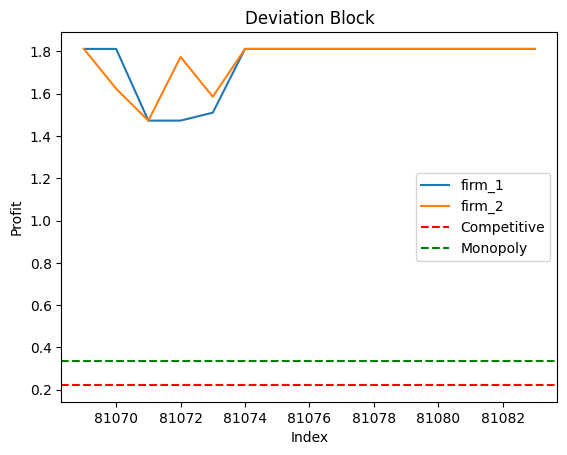

         firm_1    firm_2
80705  1.811967  1.811967
80706  1.811967  1.811967
80707  1.736625  1.811967
80708  1.472927  1.774296
80709  1.510598  1.585940
80710  1.811967  1.811967
80711  1.811967  1.811967
80712  1.811967  1.811967
80713  1.811967  1.811967
80714  1.811967  1.811967
80715  1.811967  1.811967
80716  1.811967  1.811967
80717  1.811967  1.811967
80718  1.811967  1.811967
80719  1.811967  1.811967


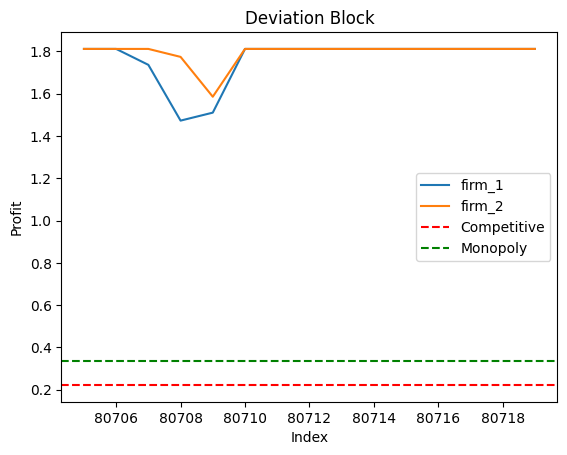

         firm_1    firm_2
79996  1.811967  1.811967
79997  1.811967  1.585940
79998  1.661283  1.661283
79999  1.472927  1.510598
80000  1.472927  1.774296
80001  1.510598  1.585940
80002  1.811967  1.811967
80003  1.811967  1.811967
80004  1.811967  1.811967
80005  1.811967  1.811967
80006  1.811967  1.811967
80007  1.811967  1.811967
80008  1.811967  1.811967
80009  1.811967  1.811967
80010  1.811967  1.811967


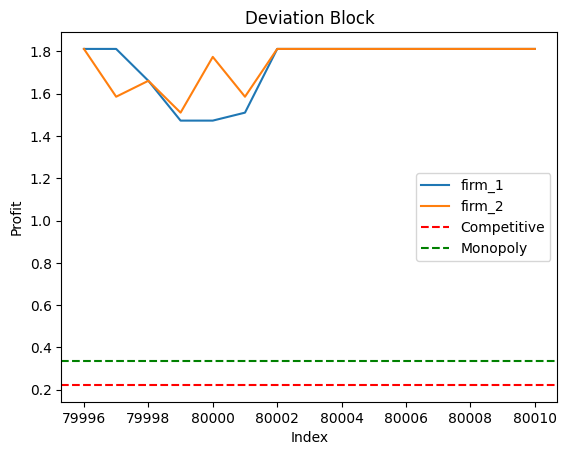

         firm_1    firm_2
79837  1.811967  1.811967
79838  1.811967  1.811967
79839  1.472927  1.811967
79840  1.472927  1.472927
79841  1.472927  1.774296
79842  1.510598  1.585940
79843  1.811967  1.811967
79844  1.811967  1.811967
79845  1.811967  1.811967
79846  1.811967  1.811967
79847  1.811967  1.811967
79848  1.811967  1.811967
79849  1.811967  1.811967
79850  1.811967  1.811967
79851  1.811967  1.811967


KeyboardInterrupt: 

In [31]:
# Example usage
plot_index_blocks(df_price_history, df_price_history_filtered.index, ['firm_1', 'firm_2'])

In [ ]:
import matplotlib.pyplot as plt

window_size = 50000

# Calculate the moving average for each firm
df_price_history_high['firm_1_MA'] = df_price_history_high['firm_1'].rolling(window=window_size).mean()
df_price_history_high['firm_2_MA'] = df_price_history_high['firm_2'].rolling(window=window_size).mean()

# Plot the moving averages
plt.figure(figsize=(14, 7))
plt.plot(df_price_history_high['firm_1_MA'], label='Firm 1 Moving Average')
plt.plot(df_price_history_high['firm_2_MA'], label='Firm 2 Moving Average')
plt.title('Moving Average of Profits for Firm 1 and Firm 2')
competitive_constant, monopoly_constant = game_equilibrium_high.p_minmax
plt.axhline(y=competitive_constant[0], color='r', linestyle='--', label='Competitive')
plt.axhline(y=monopoly_constant[0], color='g', linestyle='--', label='Monopoly')
plt.xlabel('Time')
plt.ylabel('Profit')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def plot_index_blocks(df, index_list, column_names):
    index_blocks = []
    current_block = [index_list[0]]
    
    # Find blocks of indices where there is a "jump"
    for i in range(1, len(index_list)):
        if index_list[i] != index_list[i-1] + 1:
            index_blocks.append(current_block)
            current_block = [index_list[i]]
        else:
            current_block.append(index_list[i])
    
    index_blocks.append(current_block)
    adjusted_block = adjust_block_length(index_blocks)
    
    # Plot line plots for each block
    for block in adjusted_block:
        plt.figure()
        for column_name in column_names:
            plt.plot(df.loc[block, column_name], label=column_name)
        plt.title(f'Index Block: {block}')
        plt.xlabel('Index')
        plt.ylabel('Values')
        plt.legend()
        plt.show()





In [ ]:
plot_index_blocks(df_profit_history, df_price_history_filtered.index, ['firm_1', 'firm_2'])